<a href="https://colab.research.google.com/github/vanderbilt-ml/51-callahan-mlproj-realestate/blob/feature-engineer-pipeline-v1/real_estate_project_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Real Estate Prediction and Market Intelligence

### Background
Real estate has many opportunities in which to apply data science methods.  I want to develop a model that will allow for identification of pricing assymetries in the real estate market by being able to accurately price assets and there by identify opportunities when new properties are discovered. 

### Project Description
My goal is to develop a model that can detect "good prices" in real estate markets of my choosing in order to identify deals.  Maybe I will buy one of these properties someday!

### Performance Metric + Analyses
1. *Pricing Accuracy* - can the model learn what a good price is and make a price prediction for a specific property?  This would involve predicting the price at which a property will sell based on a variety of features, and can be verified in training data by comparing the prediction with the actual sale price.  RMSE comes to mind as a possible measure of model accuracy. 

2. *Value Drivers* - which attributions associated with a property influence price and do those factors change based on geography?  Obvious things like square-foot (size) of property will matter, but there are likely other discoverable features here that provide a rich opportunity for feature engineering.  Normalizing for macro-economic trends may also be an option, since housing prices are defined inside a marketplace that is influenced by factors like: mortgage rates, inflation, GDP, etc... 

3. *Similar markets* - Which markets are complementary in the sense that they have similar attributes and properties represent a similar value to purchasers?  Identifying a similarity metric for markets would allow this analysis to encompass greater quantities of data.  Presumably, data from similar markets could be combined to make predictions while dissimilar ones should be excluded.  As an example, California beachfront property or NYC apartments are likely not comparable to a single family home in the midwest and we would not want to train data using Cali/NYC data if we want to predict home prices in rural Kansas.

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

In [5]:
eda = pd.read_csv('https://raw.githubusercontent.com/vanderbilt-ml/51-callahan-mlproj-realestate/main/northern_MI_market_total_2022-05-22.csv?token=GHSAT0AAAAAABULIU4GOX65CIEQ35PWYY7UYU4Y3SA',
                  parse_dates=['last_update', 'sold_date'],
                  infer_datetime_format=True)

eda['address_new'] = eda['address_new'].apply(literal_eval)

In [6]:
eda.head(2)

,property_id,prop_type,last_update,address,address_new,prop_status,price_raw,sqft_raw,is_showcase,is_new_construction,price,beds,baths,sqft,lot_size,photo,short_price,baths_half,baths_full,photo_count,sold_date,lat,lon,has_leadform,page_no,rank,list_tracking,listing_id,list_date,advertiser_id,agent_name,agent_photo,office_name,office_advertiser_id,price_reduced,products,price_reduced_date,is_cobroker,is_foreclosure,snapshot_date
0,3586054640,mobile,2022-03-11 00:00:00,"4439 Ironwood Dr N, Traverse City, 49685","{'line': '4439 Ironwood Dr N', 'street_number'...",recently_sold,10000,732.0,False,False,"$10,000",NaN,2,732 sq ft,0.36 acres,https://ap.rdcpix.com/840246068/2259e83a437325...,$10K,NaN,2.0,14.0,2022-02-22,44.645801,-85.665230,False,1,1,type|property|data|prop_id|3586054640|page|ran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/22/22
1,4501321015,single_family,2022-03-11 00:00:00,"4783 Cedar Knoll Dr, Traverse City, 49685","{'line': '4783 Cedar Knoll Dr', 'street_number...",recently_sold,11000,NaN,False,False,"$11,000",NaN,0,sq ft N/A,0.80 acres,https://p.rdcpix.com/v01/lfcdd4543-m0s.jpg,$11K,NaN,NaN,5.0,2021-11-29,44.756552,-85.711395,False,1,2,type|property|data|prop_id|4501321015|page|ran...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/22/22


## Questions

**Are the enough data points to perform a prediction in the geographical area of interest?**

*Yes, we have enough data to begin, and can collect more as needed.*

**What data cleaning tasks are necessary?**

*Data conversions, replacing NANs and strings, and strategically dropping some categories/columns.  Dropping foward looking values is important to avoiding leakage.*

**Is missing data a problem for any particular columns?**

*Yes, key missing values for sqft and bathrooms pose a risk.  Will need to be cautious with filling those.*

**Do any basic patterns emerge that increase/decrease trust in the dataset?**

*None that cannot be handled with data cleaning.*


In [7]:
# Question 1  
# 944 entries, 141 land (vacant lots) as well as other/commercial and farm can all be dropped.  These are non-residential properties and not the focus of this analysis. 
# 789 values in dataset.  Conclusion - small but workable, can expand information collection to neighboring areas if necessary.

display(eda.shape[0])
display(eda['prop_type'].value_counts())

prop_data = eda[ eda['prop_type'].isin(['single_family', 'condo', 'multi_family', 'mobile']) ]

display(prop_data.shape[0])
display(prop_data['prop_type'].value_counts())

944

single_family    475
condo            286
land             141
mobile            20
other             10
multi_family       8
commercial         3
farm               1
Name: prop_type, dtype: int64

789

single_family    475
condo            286
mobile            20
multi_family       8
Name: prop_type, dtype: int64

In [8]:
# Question 2

prop_data.isnull().sum()

property_id               0
prop_type                 0
last_update               0
address                   0
address_new               0
prop_status               0
price_raw                 0
sqft_raw                120
is_showcase               0
is_new_construction       0
price                     0
beds                    190
baths                     0
sqft                      0
lot_size                160
photo                     0
short_price               0
baths_half              610
baths_full              155
photo_count             159
sold_date                 0
lat                      60
lon                      60
has_leadform              0
page_no                   0
rank                      0
list_tracking             0
listing_id              276
list_date               276
advertiser_id           308
agent_name              287
agent_photo             417
office_name             276
office_advertiser_id    339
price_reduced           276
products            

## Data Cleaning

In [9]:
prop_data['last_update'] = pd.to_datetime(prop_data['last_update'], utc=True).dt.date
prop_data['list_date'] = pd.to_datetime(prop_data['list_date'], utc=True).dt.date
prop_data['price_reduced_date'] = pd.to_datetime(prop_data['price_reduced_date'], utc=True).dt.date

prop_data = prop_data[ prop_data['prop_type'].isin(['single_family', 'condo', 'multi_family']) ]

prop_data = prop_data.dropna(subset=['sqft_raw'])

prop_data = prop_data[ prop_data['sqft_raw'] > 0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [10]:
prop_data['prop_type'].value_counts()

single_family    402
condo            219
multi_family       8
Name: prop_type, dtype: int64

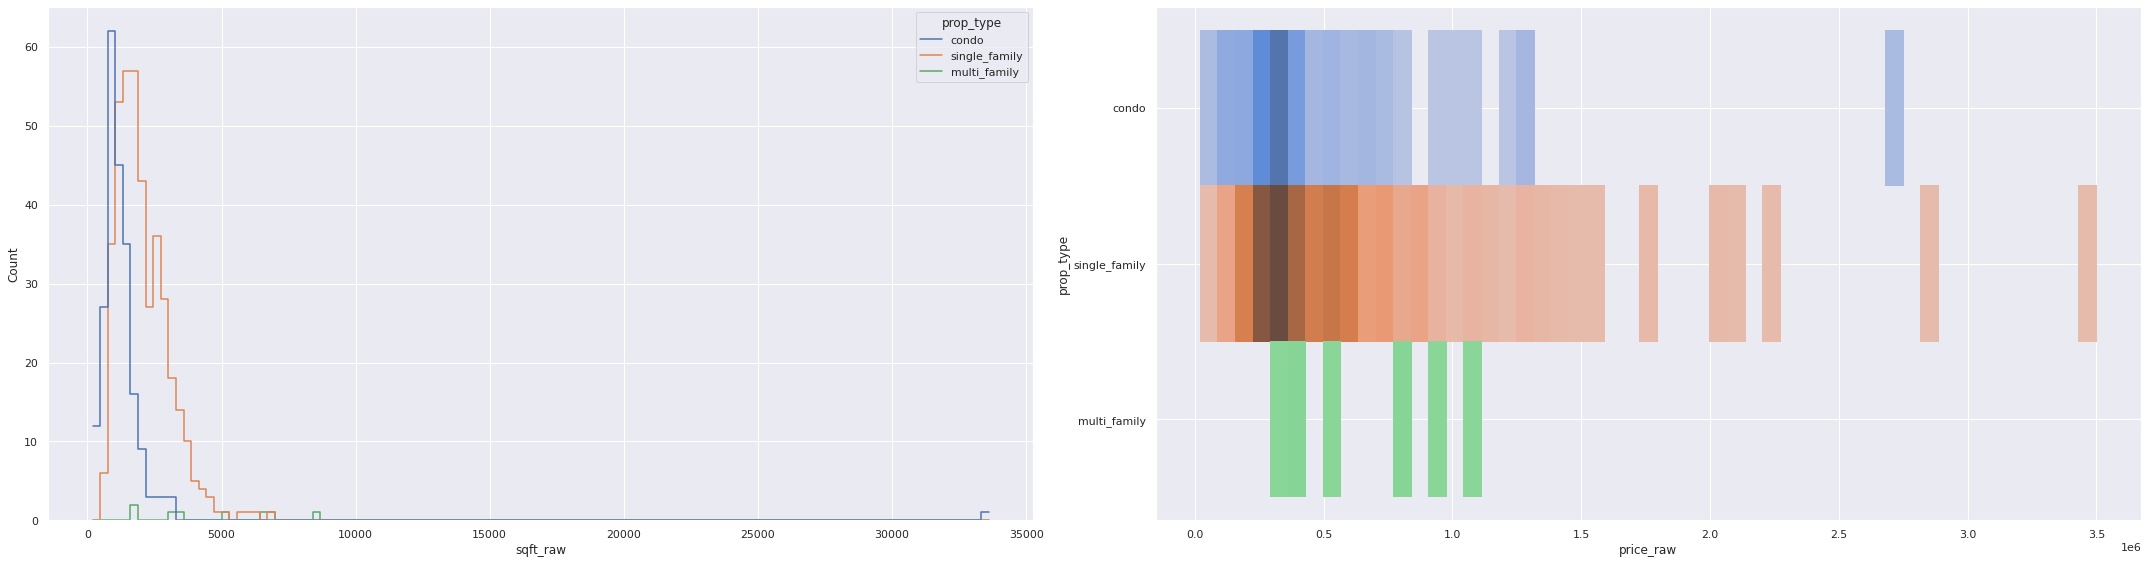

In [19]:
sns.set_theme(rc={
    'figure.autolayout':True,
    'figure.subplot.wspace':0.02}
    )

fig, ax = plt.subplots(1,2)

sns.histplot(
    data=prop_data, 
    x="sqft_raw", 
    hue='prop_type', 
    kde=False, 
    element='step', 
    fill=False,
    ax=ax[0]
)

sns.histplot(
    prop_data, 
    x="price_raw", 
    y="prop_type", 
    hue="prop_type", 
    legend=False,
    ax=ax[1]
)

fig.show()

# Feature Engineering

## Feature 1 - Address Details

In [ ]:
# Example JSON object
{'line': '4439 Ironwood Dr N', 
 'street_number': '4439', 
 'street': 'Ironwood', 
 'street_suffix': 'Dr', 
 'unit': None, 
 'city': 'Traverse City', 
 'state': 'Michigan', 
 'state_code': 'MI', 
 'postal_code': '49685', 
 'lat': 44.645801, 
 'long': -85.66523, 
 'county': 'Grand Traverse'}

In [21]:
unpacked_address = prop_data['address_new'].apply(pd.Series).drop(columns=['lat', 'long', 'street_number', 'street_suffix', 'unit'])

display(unpacked_address)

prop_data = pd.concat([prop_data, unpacked_address], 
              axis=1)


,line,street,city,state,state_code,postal_code,county
3,2035 N US Highway 31 N # 4-40,US Highway 31,Traverse City,Michigan,MI,49686,Grand Traverse
5,3877 Falling Leaf Trl,Falling Leaf,Traverse City,Michigan,MI,49686,Grand Traverse
13,2035 N US Highway 31 N # 9-34,US Highway 31,Traverse City,Michigan,MI,49686,Grand Traverse
53,4519 Briarcliff Dr,Briarcliff,Traverse City,Michigan,MI,49684,Grand Traverse
83,2035U S 31 N Us Unit 501,S 31 N Us,Traverse City,Michigan,MI,49686,Grand Traverse
...,...,...,...,...,...,...,...
926,293 Lamkin Rd,Lamkin,Harbor Springs,Michigan,MI,49740,Emmet
933,356 E 3rd St,3rd,Harbor Springs,Michigan,MI,49740,Emmet
938,575 E Bay St Bldg 12,Bay,Harbor Springs,Michigan,MI,49740,Emmet
941,1515 Andover Club Dr,Andover Club,Harbor Springs,Michigan,MI,49740,Emmet


## Feature 2 - Bathrooms 

In [22]:
prop_data['baths'] = prop_data['baths'].replace('Call', np.NaN)
prop_data['bath'] = prop_data['baths_half'].fillna(0) / 2 + prop_data['baths_full'].fillna(0)

# No bathrooms? No way.  Make these NAN and fill during pipelines later
prop_data['bath'] = prop_data['bath'].replace(0, np.NaN)


## Feature 3 - Align binary values across variable types

In [23]:
binary_cols = ['is_showcase', 'is_new_construction', 'has_leadform', 'is_cobroker', 'is_foreclosure', 'price_reduced']

prop_data[binary_cols] = prop_data[binary_cols].fillna(False)

for col in binary_cols:
    print(col)
    display(prop_data[col].value_counts(dropna=False))

is_showcase


False    629
Name: is_showcase, dtype: int64

is_new_construction


False    570
True      59
Name: is_new_construction, dtype: int64

has_leadform


False    629
Name: has_leadform, dtype: int64

is_cobroker


True     395
False    234
Name: is_cobroker, dtype: int64

is_foreclosure


False    627
True       2
Name: is_foreclosure, dtype: int64

price_reduced


False    546
True      83
Name: price_reduced, dtype: int64

## Feature 4 - Unit Conversions


In [25]:
# Extract lot sizes, convert to same units

def acres_to_sqft(row):
    if 'acres' in str(row['lot_size']):
        return float(str.strip(row['lot_size'].replace('acres', '').replace(',', ''))) * 43560
    elif 'sq ft lot' in str(row['lot_size']):
        return float(str.strip(row['lot_size'].replace('sq ft lot', '').replace(',', '')))
    elif pd.isna(row['lot_size']):
        return row['lot_size']   
    else:
        return -1   

prop_data['lot_size_sqft'] = prop_data.apply(acres_to_sqft, axis=1)

display(f"Unclassified Values: {prop_data[ prop_data['lot_size_sqft'] == -1].shape[0]}")

'Unclassified Values: 0'

## Feature 5 - Days on Market + Days at Reduced Price


In [26]:
prop_data['dom'] = (prop_data['sold_date'].dt.date - prop_data['list_date']).dt.days

prop_data['drp'] = np.where(pd.isna(prop_data['price_reduced_date']),
                                    np.NaN,
                                    (prop_data['sold_date'].dt.date  - prop_data['price_reduced_date']).dt.days)


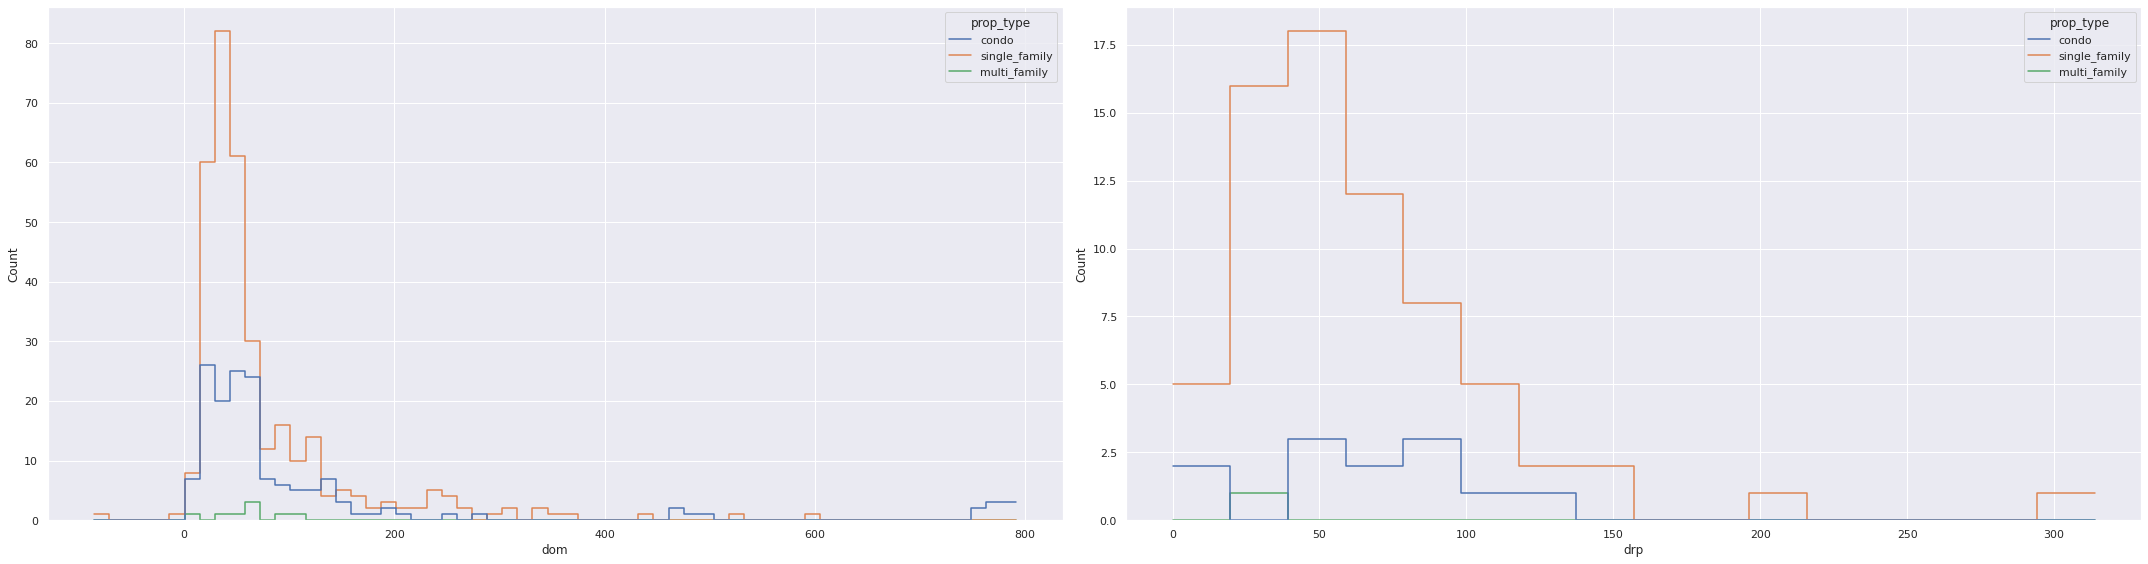

In [28]:
sns.set_theme(rc={
    # 'figure.figsize':(18,8),
    'figure.autolayout':True,
    'figure.subplot.wspace':0.02}
    )

fig, ax = plt.subplots(1,2)

sns.histplot(
    data=prop_data, 
    x="dom", 
    hue='prop_type', 
    kde=False, 
    element='step', 
    fill=False,
    ax=ax[0]
)

sns.histplot(
    data=prop_data, 
    x="drp", 
    hue='prop_type', 
    kde=False, 
    element='step', 
    fill=False,
    ax=ax[1]
)

fig.show()

In [36]:
drop_columns = ['address', 'address_new', 'prop_status', 'price', 'sqft', 'photo', 'short_price', 'products',
              'photo_count', 'page_no', 'rank', 'list_tracking', 'listing_id', 'property_id',
              'advertiser_id', 'agent_photo', 'office_name', 'office_advertiser_id', 'snapshot_date', 'agent_name']


clean_drop = ['lot_size', 'baths', 'baths_full', 'baths_half', 'price_reduced', 'price_reduced_date', 'list_date', 'lat', 'lon']


In [37]:
clean_data = prop_data.drop(columns=drop_columns + clean_drop)

In [38]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 629 entries, 3 to 942
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   prop_type            629 non-null    object        
 1   last_update          629 non-null    object        
 2   price_raw            629 non-null    int64         
 3   sqft_raw             629 non-null    float64       
 4   is_showcase          629 non-null    bool          
 5   is_new_construction  629 non-null    bool          
 6   beds                 577 non-null    float64       
 7   sold_date            629 non-null    datetime64[ns]
 8   has_leadform         629 non-null    bool          
 9   is_cobroker          629 non-null    bool          
 10  is_foreclosure       629 non-null    bool          
 11  line                 629 non-null    object        
 12  street               628 non-null    object        
 13  city                 629 non-null  

# Pipeline